# California House Pricing

*Alex Philip Berger*

6/9/2019

### Intro

In this notebook, I do Random Forest regressions to estimate (median) housing prices in California. Specifically, I focus on (Scikit Learn's) **Stratified Sampling, Imputers, Pipelines, K-fold cross validation, and Fine-tuning through grid search**. This also means less focus on other parts of the modeling process.

Data is obtained from https://www.census.gov/, with a few features removed, as well as a categorical variable (ocean_proximity) added. 

### 1. Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

# Random Seed
np.random.seed(42)

# To Configuration
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### 2. Get Data

In [2]:
def load_housing_data():
    csv_path = "data/housing/housing.csv"
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 3. Inspect Data

In [4]:
housing.info() # data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts() # distribution of the categorical variable

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe() # distributions of numerical variables

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


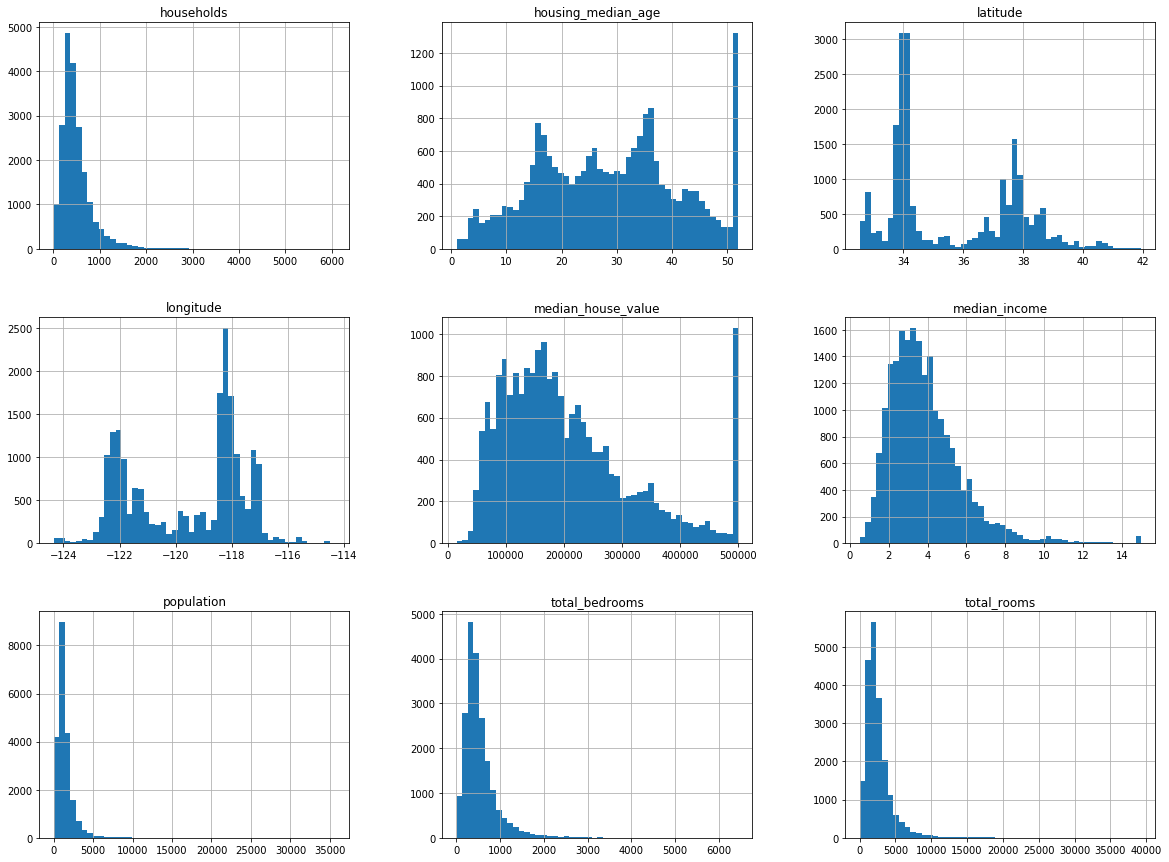

In [7]:
housing.hist(bins=50, figsize=(20,15)) # visualise distribution of numerical variables
plt.show()

### 4. Split data (Training & Test) - Version 1: Random Sampling

In [8]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [9]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### 5. Split data (Training & Test) - Version 2: Stratified Sampling

Motivation: If the *Median Income* is an important variable (in predicting housing prices), we want to ensure that the test set is representative of the various categories of incomes in the whole data set. This helps us to avoid bias when evaluating model results.

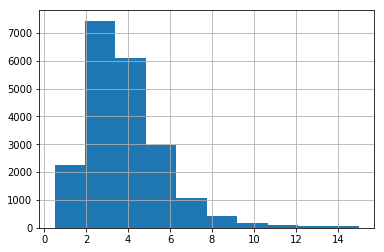

In [10]:
housing["median_income"].hist()

*Median Income* is a continuous variable, so I create an income category attribute:

In [11]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

The distribution of my newly created variable:

In [12]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

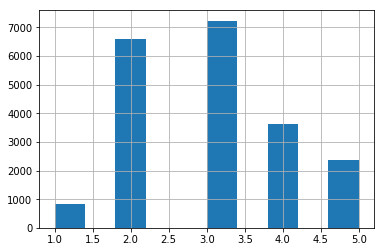

In [13]:
housing["income_cat"].hist()

I can now use Scikit Learn to create **Stratified Sampling**:

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Now, do I indeed have the same distribution of income buckets in *test* as in the full data set?

In [15]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set) # distribution in test set

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [16]:
housing["income_cat"].value_counts() / len(housing) # distribution in full data set

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Yes! Stratified Sampling is complete (with regards to *Median Income*)

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True) # delete categorical variable (as it is no longer needed)

I decide to continue with the stratified samples.

### 6. Discover and visualize data 

In this section, I only show a few examples, as it is not the focus of the notebook.

In [18]:
housing = strat_train_set.copy() # create a copy, so as not to harm the training data set

In [19]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


I plot the geographical information with information about median house value (through *alpha* and *c*) and population size (through *s*). The big cities (Los Angeles, San Fransisco, San Diego) stand out as bigger and more expensive.

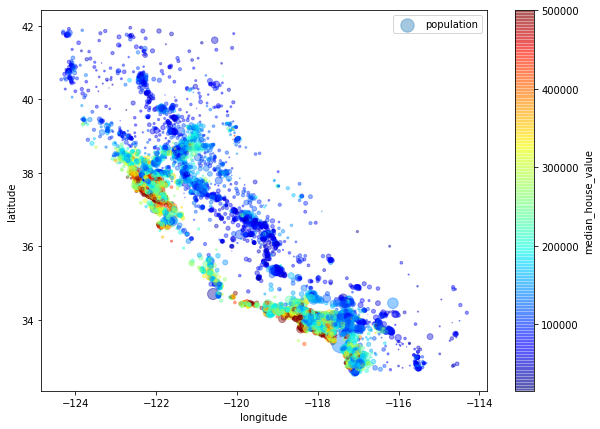

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

Correlations:

In [21]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False) # response vs explanatory

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [22]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


NameError: name 'scatter_matrix' is not defined

### 7. Prepare data for Machine Learning algorithms

Once again, I star with *strat_train_set*:

In [23]:
housing = strat_train_set.drop("median_house_value", axis = 1) # Remove column to be predicted
housing_labels = strat_train_set["median_house_value"].copy() # Column to be predicted

In [28]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [70]:
housing_num.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
dtype: int64

Data Cleaning

1. First, NA replacement with Scikit Learn's **Simple Imputer Class** (numerical values):

In [72]:
from sklearn.impute import SimpleImputer # import the Simple Imputer Class
imputer = SimpleImputer(strategy="median") # impute with median values

housing_num = housing.drop("ocean_proximity", axis = 1) # drop non-numerical columns
imputer.fit(housing_num) # fit the imputer instance (= calculate median of all columns)
imputer.statistics_ # output the calculated median values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [73]:
X = imputer.transform(housing_num) # Apply imputer (NB: All columns)
housing_tr = pd.DataFrame(X, columns=housing_num.columns) # Transform NumPy array to DataFrame

In [74]:
housing_tr.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

2. Next, I convert text/categoI handle the text attribute (*ocean_proximity*) which I convert from text to numbers, with Scikit Learn's **Ordinal Encoder Class**.

In [76]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(5)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [79]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10] # categories are transformed to numbers

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

3. Step 2 is not meaningful yet, as the *order* of category values has no meaning. Because of this, one-hot encoding is needed (through Scikit Learn's **OneHotEncoder class**):

In [81]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [82]:
from sklearn.preprocessing import OneHotEncoder 
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [84]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [86]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]